---
layout: post
title: "Auto Encoder란 무엇일까?"
author: "Chanjun Kim"
categories: Data분석
tags: [Data, AutoEncoder, AE, Gan, Denoising AE, VAE, 딥러닝, CNN]
image: 08_AutoEncoder.png
---

## **학습목적**
이 포스팅에선 GAN을 배우기 전 이미지를 생성하는 오토인코더에 대해서 알아보도록 하겠습니다.<br>

#### **오토인코더란?**
- 오토인코더(Autoencoder)의 기본적인 개념은 저차원(직관적)인 데이터를 고차원(추상적)의 데이터로 표현(representation)하고 다시 저차원의 데이터로 만들어 데이터 생성, 노이즈 제거, 특성 변화 등을 할 수 있도록 만들어주는 기법으로, 오토 인코더라고 불리지만 실제로는 인코더와 디코더가 같이 묶여있는 네트워크이다.
    - 저차원과 고차원
        - 인코더는 차원 축소라고 표현되나, 잠재공간(Latent Space)가 늘어나며 추상적인 고차원 데이터로 변환된다.
        - 128x128x3의 이미지는 사람의 눈으로도 판단 가능한 직관적인 데이터지만 2x2x32 같이 잠재공간(Latent Space)가 많은 경우는 사람의 눈으로는 판단할 수 없는 추상적인 데이터라고 볼 수 있다.

<br>

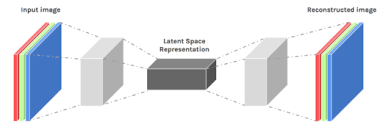

> 출처: https://excelsior-cjh.tistory.com/187

---

#### **오토인코더 실습**
- 단순한 데이터셋(mnist 등)를 통하여 잠재 공간에 어떻게 표현되는 지 확인하고 고차원의 데이터를 실습한 후 AE의 한계점을 이해하고 이것을 해결한 VAE까지 소개하도록 하겠습니다.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd drive/MyDrive/cj/portfolio/Chanjun-kim.github.io/_ipynb
!pwd

Mounted at /content/drive
/content/drive/MyDrive/cj/portfolio/Chanjun-kim.github.io/_ipynb
/content/drive/MyDrive/cj/portfolio/Chanjun-kim.github.io/_ipynb


In [ ]:
import os
import sys
import warnings

import random

import numpy as np
import pandas as pd

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib as mpl
import matplotlib.pyplot as plt
from plotnine import * 

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist, fashion_mnist

In [ ]:
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [47]:
class Autoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout = False
        ):

        self.name = 'autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):

        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        encoder_output= Dense(self.z_dim, name='encoder_output')(x)

        self.encoder = Model(encoder_input, encoder_output)


        ### THE DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                x = LeakyReLU()(x)
                
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL AUTOENCODER
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)
        
    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(lr=learning_rate)

        self.model.compile(optimizer=optimizer, loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")) 

    def train(self, x_train, batch_size, epochs, verbose = 1):
      self.model.fit(     
        x_train
        , x_train
        , batch_size = batch_size
        , shuffle = True
        , epochs = epochs
        , verbose = verbose
      )               

> 출처 : https://github.com/davidADSP/GDL_code

1. 최초의 데이터를 28 x 28 데이터를 인풋으로 받습니다.
2. Encoder와 Decoder의 깊이는 len(encoder_conv_filters), len(decoder_conv_t_filters)로 정해지므로 각각 4개의 Convolution 층을 갖게 됩니다.
   - Convolution Filter의 차원은 1(Grey Scale Input) - (32 - 64 - 64 -64, Encoder Convolution Filter) - 2(represention) - (64 - 64 - 32, Decoder Convolution Filter) - 1(Grey Scale Output) 으로 구성됩니다.
3. Encoder와 Decoder 모두 Activation Function은 LeakyRelu를 활용합니다.
4. kernel size는 3x3으로 진행됩니다.
5. stride를 2로 주어 차원 1/2로 축소합니다.
6. encoder의 최종 차원을 2차원으로 만들어 잠재공간에 어떻게 분포되는지 확인하겠습니다.
7. loss function은 MSE를 사용하고 최종 Activation function은 Sigmoid를 사용합니다.
8. Optimizer는 Adam을 활용합니다.
9. Auto Encoder 같은 경우는 Input과 Output이 같습니다. 그렇기 때문에 마지막 fit 부분에 x = x_train, y = x_train으로 들어가게 됩니다.

In [48]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

In [49]:
AE.compile(0.00005)

In [ ]:
AE.encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0     

In [ ]:
AE.decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

In [ ]:
mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


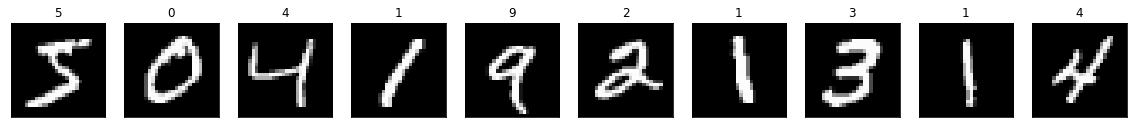

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [50]:
AE.train(x_train, batch_size = 32, epochs = 100)

Epoch 1/100
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0712
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0551
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0535
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0522
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0513
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0506
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0501
Epoch 8/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0497
Epoch 9/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0492
Epoch 10/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0488
Epoch 11/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0485
Epoch 12/100
1875/1875 [==============================] - 8s 4ms/step - lo

In [52]:
AE.model.save("h5/ae.h5")
AE.encoder.save("h5/ae_encoder.h5")
AE.decoder.save("h5/ae_decoder.h5")

In [58]:
latent_splace_x_test = pd.DataFrame(AE.encoder.predict(x_test), columns = ["x", "y"])
latent_splace_x_test["label"] = y_test
latent_splace_x_test["label"] = latent_splace_x_test.label.astype(str)

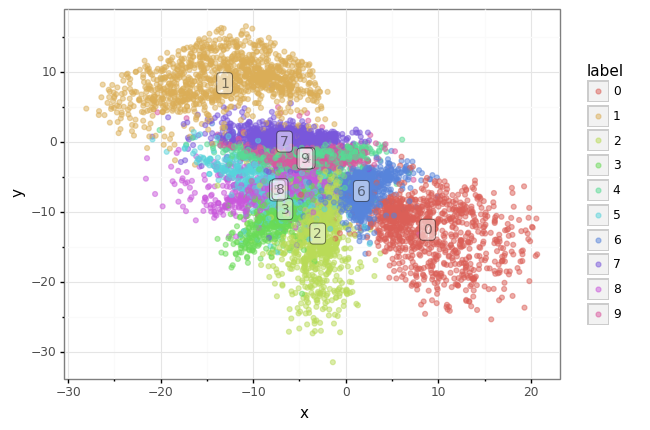

<ggplot: (8782173022201)>

In [60]:
(
    ggplot() +
 geom_point(data = latent_splace_x_test, mapping = aes(x = "x", y = "y", color = "label"), alpha = 0.5) + 
 geom_label(data = latent_splace_x_test.groupby("label").mean(["x", "y"]).reset_index(), mapping = aes(x = "x", y = "y", label = "label"), size = 10, alpha = 0.5) +
 theme_bw()
)

In [62]:
predict_x = AE.model.predict(x_test)

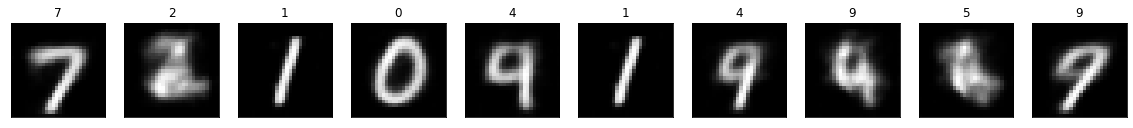

In [68]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.reshape(predict_x[i], (28, 28)))
    plt.title(y_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()